<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

# create data

In [0]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

In [3]:
features[0], labels[0]

(
 [2.2122064 0.7740038]
 <NDArray 2 @cpu(0)>, 
 [6.000587]
 <NDArray 1 @cpu(0)>)

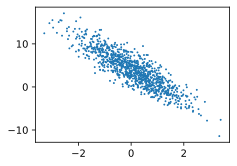

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1);  # 加分号只显示图

# batch

In [0]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)  # take函数根据索引返回对应元素

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[-1.2358273  -2.2571874 ]
 [ 0.43030912  0.6295902 ]
 [ 0.29968393  1.0723529 ]
 [-0.30573937 -0.9590651 ]
 [-0.23048367  0.7954761 ]
 [-1.9768796  -0.20801921]
 [-0.11494503  1.7983674 ]
 [ 0.13259305  0.31313723]
 [-1.130275    0.3379702 ]
 [-0.29123184 -0.25115967]]
<NDArray 10x2 @cpu(0)> 
[ 9.421468    2.9229968   1.1482164   6.8569913   1.0299395   0.94550216
 -2.1227243   3.4094667   0.7970579   4.467789  ]
<NDArray 10 @cpu(0)>


# init params

In [0]:
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))

w.attach_grad()
b.attach_grad()

# define model

In [0]:
def linreg(X, w, b): # 本函数已保存在d2lzh包中方便以后使用
  return nd.dot(X, w) + b

# define loss

In [0]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh包中方便以后使用
  return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# def gradient decent method

In [0]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh包中方便以后使用
  for param in params:
    param[:] = param - lr * param.grad / batch_size

# trainning

In [0]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [12]:
for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.040729
epoch 2, loss 0.000153
epoch 3, loss 0.000050


In [13]:
true_w, w

([2, -3.4], 
 [[ 1.9998806]
  [-3.399601 ]]
 <NDArray 2x1 @cpu(0)>)

In [14]:
true_b, b

(4.2, 
 [4.199822]
 <NDArray 1 @cpu(0)>)

# predict

In [0]:
y_pred = linreg(features,w,b)

In [16]:
import pandas as pd
res = pd.DataFrame()
res['x0'] = features[:,0].asnumpy()
res['x1'] = features[:,1].asnumpy()
res['y'] = labels.asnumpy()
res['y_pred'] = y_pred.reshape(labels.shape).asnumpy()
res = res.sort_values(by='x1')
res

,x0,x1,y,y_pred
142,-1.492531,-3.299234,12.443539,12.431017
434,0.017306,-3.104724,14.796693,14.789255
421,0.563263,-2.989000,15.501279,15.487688
639,-0.263142,-2.962772,13.766514,13.745811
567,-0.612709,-2.819966,12.554433,12.561235
...,...,...,...,...
50,-0.903647,2.650805,-6.627749,-6.619044
467,0.929791,2.800923,-3.464675,-3.462727
888,-1.122059,2.883526,-7.828708,-7.847001
557,-2.118665,3.349377,-11.421704,-11.423801


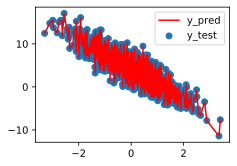

In [17]:
plt.scatter(res['x1'],res['y'],label='y_test')
plt.plot(res['x1'],res['y_pred'],color='red',label='y_pred')
plt.legend()